# Logistic Regression using gradient descent

Inspired by the Coursera Course <i>Neural Networks and Deep Learning</i> by deeplearning.ai

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

## Data collection & analysis

For this example the MNIST dataset will be used. A binary classification will be trained to detect whether a handwritten digit is a 5 or not

In [2]:
digits = datasets.load_digits()

Image shows a handwritten 4


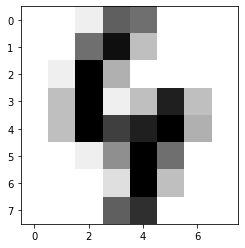

In [3]:
# Show one handwritten digit
test_idx = 111
plt.imshow(digits.images[test_idx], cmap=plt.cm.gray_r) #use grey color scale
print('Image shows a handwritten {}'.format(digits.target[test_idx]))

In [4]:
# Check sizes
digits.images.shape
digits.target.shape
print('The dataset contains {} images, each with a size of {} by {} pixels'.format(digits.images.shape[0],digits.images.shape[1],digits.images.shape[2]))

The dataset contains 1797 images, each with a size of 8 by 8 pixels


In [5]:
#Check dimensions of images and targets
print('Shape of input {}'.format(digits.images.shape))
print('Shape of target {}'.format(digits.target.shape))

Shape of input (1797, 8, 8)
Shape of target (1797,)


In [6]:
# Check image statistics
print('Minimum Value = {}'.format(np.min(digits.images)))
print('Maximum Value = {}'.format(np.max(digits.images)))

Minimum Value = 0.0
Maximum Value = 16.0


<BarContainer object of 10 artists>

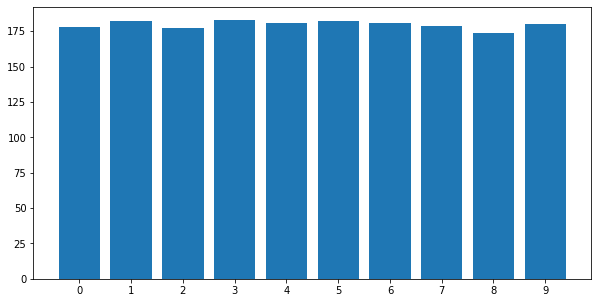

In [7]:
# Check target distribution
plt.figure(figsize=(10,5))
digits_count = np.array([sum(digits.target==i) for i in digits.target_names])
plt.bar(digits.target_names,digits_count,tick_label=digits.target_names)

In [8]:
for i in range(10):
    print('{}:{}'.format(digits.target_names[i],digits_count[i]))

0:178
1:182
2:177
3:183
4:181
5:182
6:181
7:179
8:174
9:180


<BarContainer object of 2 artists>

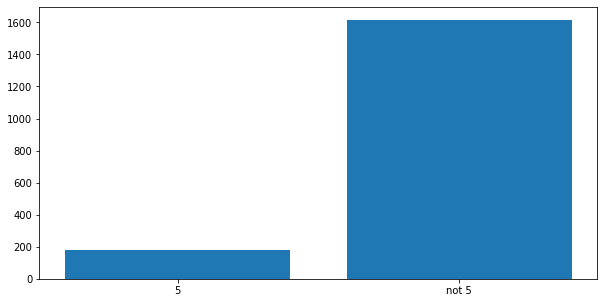

In [9]:
# Show distribution of binary classification 5 vs. not 5 (one-vs-rest)
plt.figure(figsize=(10,5))
binary_targets = ["5","not 5"]
binary_count = np.array(digits_count[5])
binary_count = np.append(binary_count,(sum([digits_count[i] for i in range(10) if i != 5])))
plt.bar(binary_targets,binary_count,tick_label=binary_targets)

In [10]:
for i in range(2):
     print('{}: {}'.format(binary_targets[i],binary_count[i]))
print("Factor 1 to {}".format(int(round(binary_count[1]/binary_count[0],0))))

5: 182
not 5: 1615
Factor 1 to 9


## Data preparation

In [11]:
#Upscale data -> From 1:9 to approx. 1:1
upscaled_images = digits.images
upscaled_target = digits.target
for i in range(8):
    upscaled_images = np.concatenate((upscaled_images,digits.images[digits.target==5]))
    upscaled_target = np.concatenate((upscaled_target,digits.target[digits.target==5]))

In [12]:
upscaled_images.shape, upscaled_target.shape

((3253, 8, 8), (3253,))

<BarContainer object of 2 artists>

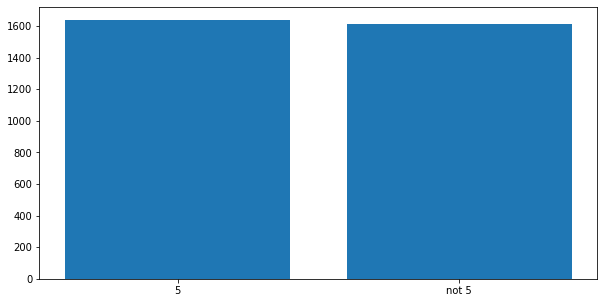

In [13]:
# Show distribution of binary classification 5 vs. not 5 (one-vs-rest)
plt.figure(figsize=(10,5))
binary_targets = ["5","not 5"]
binary_count = np.array(np.sum(upscaled_target==5))
binary_count = np.append(binary_count,(sum([1 for i in upscaled_target if i != 5])))
plt.bar(binary_targets,binary_count,tick_label=binary_targets)

In [14]:
for i in range(2):
     print('{}: {}'.format(binary_targets[i],binary_count[i]))
print("Factor 1 to {}".format(int(round(binary_count[1]/binary_count[0],0))))

5: 1638
not 5: 1615
Factor 1 to 1


In [15]:
images = upscaled_images
targets = upscaled_target

In [16]:
# Split data into test and training set
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size=0.2, random_state=42)

In [17]:
print('Number of train examples {}'.format(images_train.shape[0]))
print('Number of test example {}'.format(images_test.shape[0]))

Number of train examples 2602
Number of test example 651


In [18]:
# Reshape inputs to be of size (image pixels width * pixels height, number of examples)
# So that each pixel is converted into a feature
X_train = images_train.reshape(images_train.shape[0],-1).T
X_test = images_test.reshape(images_test.shape[0],-1).T

print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of X_test: {}'.format(X_test.shape))

Shape of X_train: (64, 2602)
Shape of X_test: (64, 651)


In [19]:
#Reshape targets to be of size (number of target dimensions, number of examples)
Y_train = targets_train.reshape(1,-1)
Y_test = targets_test.reshape(1,-1)

print('Shape of Y_train: {}'.format(Y_train.shape))
print('Shape of Y_test: {}'.format(Y_test.shape))

Shape of Y_train: (1, 2602)
Shape of Y_test: (1, 651)


In [20]:
# Normalize data by dividing with max pixel value
X_train = X_train / 16
X_test = X_test / 16

In [21]:
# Sanity check
np.min(X_train), np.max(X_train)

(0.0, 1.0)

In [22]:
# Convert Y values into binary classification
Y_train = np.array([1 if i == 5 else 0 for i in Y_train.ravel() ]).reshape(1,-1)
Y_test = np.array([1 if i == 5 else 0 for i in Y_test.ravel() ]).reshape(1,-1)

## Build Model

### Define Functions

In [23]:
# Sigmoid Activation Function
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [24]:
# Calculate regression function w^T*X+b
def forwardpropagation(X,w,b):
    return sigmoid(np.dot(w.T,X)+b)

In [25]:
# Do backpropagation during gradient descent to update the parameters w and b
def backpropagation(X,Y,A,w,b, learning_rate):
    m = X.shape[1]
    # Compute Cost
    cost = -(np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)))/m
    
    #Compute gradients
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum(A-Y)/m
    
    #Update parameters
    w -= learning_rate * dw
    b -= learning_rate * db
    
    return w,b,cost

In [26]:
# Predict binary classification
def predict(X,w,b):
    return np.array([1 if a > 0.5 else 0 for a in forwardpropagation(X,w,b)[0]]).reshape(1,-1)

In [27]:
# Evalute binary classifications using accuracy
def evaluate_predictions(Y,Y_Pred):
    return np.sum(Y == Y_Pred)/Y.shape[1]

In [28]:
class LogisticRegression():
    def __init__(self, number_of_dimensions):
        # initialize parameters with random values
        self.w = np.zeros((number_of_dimensions,1))
        self.b = 0
        self.costs = []
    def fit(self,X,Y, learning_rate=0.001, num_iterations=1000, verbose=True):
        for i in range(num_iterations):
            # Forward Propagation
            A = forwardpropagation(X,self.w,self.b)
            # Backpropagation
            self.w,self.b,cost = backpropagation(X,Y,A,self.w,self.b,learning_rate)
            self.costs.append(cost)
            # Print costs for every 100th iteration
            if verbose and (i+1) % 1000 == 0 or (i+1) == 1:
                print ('{}. Iteration. Costs: {}'.format(i+1,cost))
    def predict(self,X):
        return predict(X,self.w,self.b)

## Train Model

In [29]:
# Get Model Instance
lr_model = LogisticRegression(X_train.shape[0])

In [30]:
# Fit Model using Training Data
learning_rate= 0.01
lr_model.fit(X_train,Y_train, learning_rate=learning_rate, num_iterations=15000)

1. Iteration. Costs: 0.6931471805599452
1000. Iteration. Costs: 0.25965059310979366
2000. Iteration. Costs: 0.17799281687717572
3000. Iteration. Costs: 0.14320511905611416
4000. Iteration. Costs: 0.12350170449746092
5000. Iteration. Costs: 0.1106109225908931
6000. Iteration. Costs: 0.10140699329408591
7000. Iteration. Costs: 0.0944383543915893
8000. Iteration. Costs: 0.08893531130472851
9000. Iteration. Costs: 0.08444991317933377
10000. Iteration. Costs: 0.08070279654549681
11000. Iteration. Costs: 0.07751016926302286
12000. Iteration. Costs: 0.07474585160750712
13000. Iteration. Costs: 0.07232015115415988
14000. Iteration. Costs: 0.07016744011991574
15000. Iteration. Costs: 0.06823850988551708


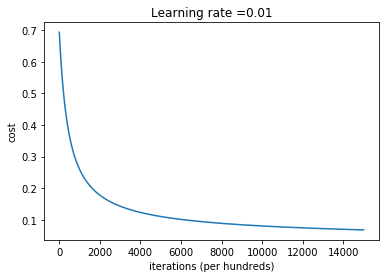

In [31]:
# Plot learning curve (with costs)
plt.plot(lr_model.costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

## Evalute Model

In [32]:
#Evaluate on training data
Y_train_pred = lr_model.predict(X_train)
train_accuracy = evaluate_predictions(Y_train,Y_train_pred)

# Evaluate on unseen data
Y_test_pred = lr_model.predict(X_test)
test_accuracy = evaluate_predictions(Y_test,Y_test_pred)

print('Accuracy on Training Data: {}%'.format(train_accuracy*100))
print('Accuracy on Test Data: {}%'.format(test_accuracy*100))

Accuracy on Training Data: 98.65488086087625%
Accuracy on Test Data: 98.46390168970814%


### Analyze wrong predictions

In [33]:
# Get wrong predictions indexes
wrong_prediction_idx = np.arange(Y_test.shape[1])[np.array((Y_test == Y_test_pred) == False).reshape(-1)]

In [34]:
wrong_prediction_idx

array([ 43,  50, 245, 266, 286, 356, 380, 453, 479, 530])

In [35]:
# Undo Preprocessing for picture
def undo_preprocessing(X, undo_normalization=True, undo_flattening=True):
    X_new = X
    # Undo normalization
    if undo_normalization:
        X_new = X_new * 16
    
    # Undo flattening
    if undo_flattening:
        X_new = X_new.T.reshape(-1,8,8)
    
    return X_new

Predicted as 5


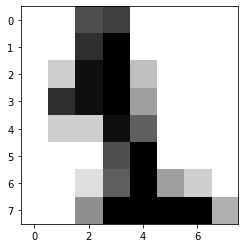

In [36]:
# Show prediction with image
idx = wrong_prediction_idx[0]
if Y_test_pred[0][idx] == 1:
    predicted_string = "5"
else:
    predicted_string = "not 5"
print('Predicted as {}'.format(predicted_string))

# Undo normalization
# Undo unraveling
# Show the handwritten digit
plt.imshow(undo_preprocessing(X_test[:,idx])[0], cmap=plt.cm.gray_r) #use grey color scale